In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, classifier

2024-02-15 23:45:54.438972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 23:45:54.439038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 23:45:54.440057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 23:45:54.447344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 23:45:55.524875: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:1000]}

In [3]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

input_features_reduced_further = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)']

label_features=['EW', 'EW_Type', 'EW_Node', 'EW_Node_Location', 'NS', 'NS_Type', 'NS_Node', 'NS_Node_Location']

ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes,
                                      input_features=input_features_reduced_further,
                                      with_labels=True,
                                      train_val_split=0.8,
                                      input_stride=2,
                                      padding='zero',
                                      scale=True,
                                      per_object_scaling=False,
                                      transform_features=False,
                                      pad_location_labels=0,
                                      input_history_steps=1,
                                      input_future_steps=128,
                                      seed=181)


=========================Creating Generator=======================
Seed: 181
nTrain: 1520 nVal: 380 (0.80)
Padding: zero
Horizons: 1-128 @ stride 2
Scaling: True  
Final input features: ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)']
=========================Finished Generator=======================


In [4]:
train_combined, val_combined = ds_gen.get_datasets(batch_size=512, 
                                                   label_features=['EW_Type', 'NS_Type'],#, 'NS_Type'], 
                                                   with_identifier=False, 
                                                   only_nodes=True, 
                                                   shuffle=True, 
                                                   stride=1)

print(train_combined.element_spec)

2024-02-15 23:47:28.354153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 23:47:28.378492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 23:47:28.378580: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 23:47:28.380336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 23:47:28.380427: I external/local_xla/xla/stream_executor

Train-DS Cardinality: tf.Tensor(5291, shape=(), dtype=int64)
(TensorSpec(shape=(None, 65, 6), dtype=tf.float64, name=None), {'EW_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 65, 6)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 57, 32)               1760      ['Input[0][0]']               
                                                                                                  
 activation (Activation)     (None, 57, 32)               0         ['conv1d[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)           (None, 52, 32)               6176      ['activation[0][0]']          
                                                                                              

2024-02-15 23:47:41.975758: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-15 23:47:43.599791: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd1d8008cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 23:47:43.599851: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-02-15 23:47:43.610024: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708037263.761108  465660 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 - 9s - loss: 1.9327 - EW_Type_loss: 1.0540 - NS_Type_loss: 0.8446 - EW_Type_accuracy: 0.4372 - NS_Type_accuracy: 0.7159 - val_loss: 1.7234 - val_EW_Type_loss: 0.9437 - val_NS_Type_loss: 0.7452 - val_EW_Type_accuracy: 0.5928 - val_NS_Type_accuracy: 0.7193 - 9s/epoch - 784ms/step
Epoch 2/200
11/11 - 0s - loss: 1.6794 - EW_Type_loss: 0.9097 - NS_Type_loss: 0.7349 - EW_Type_accuracy: 0.5878 - NS_Type_accuracy: 0.7165 - val_loss: 1.5734 - val_EW_Type_loss: 0.8588 - val_NS_Type_loss: 0.6794 - val_EW_Type_accuracy: 0.5846 - val_NS_Type_accuracy: 0.7193 - 256ms/epoch - 23ms/step
Epoch 3/200
11/11 - 0s - loss: 1.4671 - EW_Type_loss: 0.7487 - NS_Type_loss: 0.6832 - EW_Type_accuracy: 0.6812 - NS_Type_accuracy: 0.7165 - val_loss: 1.3906 - val_EW_Type_loss: 0.7180 - val_NS_Type_loss: 0.6373 - val_EW_Type_accuracy: 0.6826 - val_NS_Type_accuracy: 0.7193 - 261ms/epoch - 24ms/step
Epoch 4/200
11/11 - 0s - loss: 1.3571 - EW_Type_loss: 0.6712 - NS_Type_loss: 0.6504 - EW_Type_accuracy: 0.7112 - NS_T

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[0.13285690546035767,
 0.025581620633602142,
 0.016597671434283257,
 0.9922509789466858,
 0.9952750205993652]

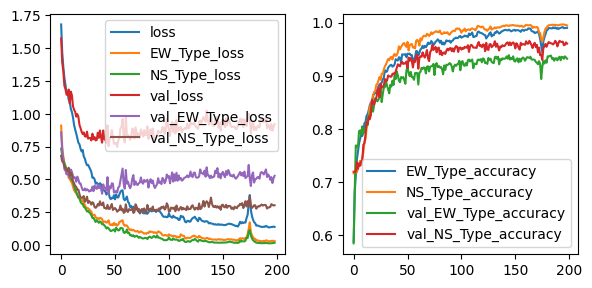

In [5]:


#dense_model = prediction_models.Dense_NN(val_combined, conv1d_layers=[], dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[30000,0.9], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[16], l2_reg=0.0001, input_dropout=0.1, mixed_dropout=0.5, lr_scheduler=[10000,0.9], seed=0)
#dense_model = prediction_models.LSTM_NN(train_combined, input_dropout=0.0, mixed_dropout=0.25, lstm_layers=[32,16], dense_layers=[32,16], l2_reg=0.0, lr_scheduler=[25000,0.9], seed=1)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[1], l2_reg=0.00001, mixed_dropout=0.2, lr_scheduler=[70000,0.9], seed=0)

dense_model = prediction_models.Dense_NN(val_combined,
                                         conv1d_layers=[[32,9],[32,6],[32,3]],
                                         dense_layers=[32,16],
                                         lstm_layers=[],
                                         l2_reg=0.0002,
                                         input_dropout=0.0,
                                         mixed_dropout_dense=0.0,
                                         mixed_dropout_cnn=0.0,
                                         mixed_dropout_lstm=0.0,
                                         mixed_batchnorm=False, # if True, this fucks up inference big time! maybe re-visit?
                                         lr_scheduler=[0.005, 250, 0.9],
                                         seed=0)

#dense_model._model = create_timeseries_classification_model((65,6))

dense_model.summary()

# temporary fix to allow class weights
# train_combined= train_combined.map(lambda x,y:(x,y[f'EW_Type']))
# val_combined = val_combined.map(lambda x,y:(x,y[f'EW_Type'])) 

# w_0 = 1.05
# w_1 = 1.2
# w_2 = 1.05
# w_3 = 0.65

hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=200, verbose=2, plot_hist=True, save_best_only=False,
                       #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                       callbacks=[])
dense_model.evaluate(train_combined)
#dense_model.model.save('models/ew_ns_classifier_new.hdf5')
#0.04
#0.22

In [6]:
pickle.dump(ds_gen.scaler, open('submission/models/ew_ns_classifier_scaler_oneshot_cnn.pkl', 'wb'))

In [ ]:
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=100, verbose=2, plot_hist=True, callbacks=[])

In [6]:
#dense_model.model.save('submission/models/ew_ns_classifier.hdf5')

In [6]:
pred_df = classifier.create_prediction_df(ds_gen=ds_gen,
                                model=dense_model,
                                train=False,
                                test=False,
                                model_outputs=['EW_Type', 'NS_Type'],#, 'NS_Type'],
                                object_limit=None,
                                only_nodes=True,
                                confusion_matrix=False,
                                prediction_batches=4,
                                verbose=1)

1/1 [==============================] - 0s 342ms/step


In [7]:
ground_truth_df = pd.read_csv(challenge_data_dir / 'train_labels.csv')#.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
majority_df = classifier.apply_one_shot_method(preds_df=pred_df, location_df=ground_truth_df, dirs=['EW', 'NS'])
print(majority_df.head(5))

   ObjectID  TimeIndex Direction Node Type
0         3          0        EW   SS   CK
1         3          0        NS   SS   CK
2        12          0        EW   SS   CK
3        12          0        NS   SS   NK
4        17          0        EW   SS   EK


In [8]:
# ground_truth_df=ground_truth_df.loc[ground_truth_df['TimeIndex']==0]
# majority_df=majority_df.loc[majority_df['TimeIndex']==0]
# ground_truth_df=ground_truth_df.loc[ground_truth_df['Direction']=='EW']
# majority_df=majority_df.loc[majority_df['Direction']=='EW']

# 0.95 with 3-layer cnn and 128@2 horizon

evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_df, participant=majority_df)
precision, recall, f2, rmse, total_tp, total_fp, total_fn, total_df = evaluator.score()
print(f'Precision: {precision:.3f}')
print(f'TP: {total_tp} FP: {total_fp}')

Precision: 0.950
TP: 1748 FP: 92


In [9]:
print(dense_model.model.optimizer.learning_rate)

<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.0021523356>


In [10]:
pickle.dump(ds_gen.scaler, open('submission/models/ew_ns_classifier_scaler_oneshot_cnn.pkl', 'wb'))
dense_model.model.save('submission/models/ew_ns_classifier_oneshot_cnn.hdf5')

#0.12 0.92 0.950 (no dropout, strong overfitting, no ft-transform)

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
